## Análise de Resultados - Live Trading Portfolio

### Considerações iniciais

Nesta análise exploratória irei obter os dados de performance mais relevantes para um porfolio de algoritmos que rodou em Live Trading por 1 ano. <br>
Este é um portfolio quem operou exclusivamente no intraday, requerendo muito menos margem operacional. Foi considerada, portanto, uma exposição de risco máxima em margem de 30% para o portfolio de algoritmos, enquanto os outros 70% foram alocados em produtos de renda fixa. <br>

Iremos explorar as principais métricas relacionadas a avaliação de performance, focando na comparação do portfolio com a aplicação buy and hold no benchmark de referência. <br><br>
Depósito inicial: R$ 50.000,00<br>
Percentual alocado em margem - 30% = R$ 15.000<br>
Percentual alocado em renda fixa - 70% = R$ 35.000


#### Carregando o arquivo de relatório de performance e importação de bibliotecas

In [788]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import linregress
from bcb import sgs

# Datas
inicio = '2023-08-31'
fim = '2024-08-31'

# Depósito
initial_deposit = 50000

# Carregar arquivo importado do mt5
file_path = r'G:\Meu Drive\Box\Projects\Production\ReportHistory-201061_1year.xlsx'
df = pd.read_excel(file_path)

c:\Users\davim\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


#### É necessário fazer a limpeza e tratamento dos dados para obter o dataframe correto

In [789]:
# Vamos recarregar a planilha Excel em um dataframe, ignorando as primeiras 6 linhas (que contêm metadados do relatório)
df = pd.read_excel(file_path, skiprows=6)

# Encontre a posição da linha que contém "Orders"
orders_index = df[df.apply(lambda row: row.astype(str).str.contains('Orders', case=False).any(), axis=1)].index

if not orders_index.empty:
    # Pegue o índice da primeira ocorrência de "Orders"
    orders_index = orders_index[0]
    
    # Mantenha apenas as linhas acima do índice encontrado
    df = df.iloc[:orders_index]
    
    # Reinicie o índice do dataframe
    df.reset_index(drop=True, inplace=True)    

    # Verifique se a coluna "Profit" está presente
    if 'Profit' in df.columns:
        # Converta a coluna "Profit" para valores numéricos, forçando erros a NaN
        df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')

        # Remova as linhas onde 'Profit' é NaN
        df = df.dropna(subset=['Profit'])
    else:
        print("A coluna 'Profit' não foi encontrada.")
else:
    print("A palavra 'Orders' não foi encontrada no DataFrame.")

c:\Users\davim\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


#### Com o dataframe pronto, calculamos o lucro total do sistema e plotamos a sua curva de capital<br>
Vamos criar também um novo dataframe para armazenar as métricas de performance que serão calculadas, começamos armenando o lucro total do sistema e seu CAGR (crescimento anual composto).

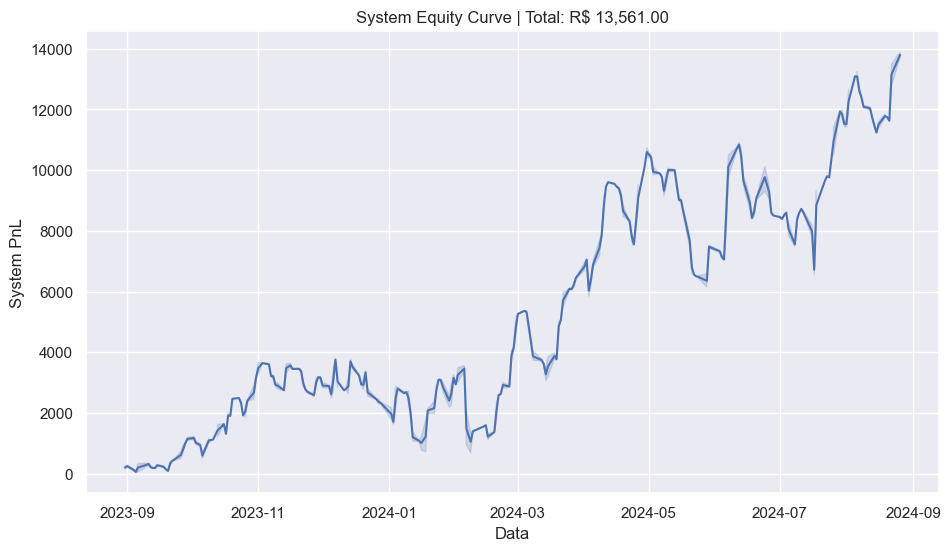

,Métrica,Trading System
0,Deposit,R$ 50000.00
1,Lucro,R$ 13561.00
2,CAGR,27.48%


In [790]:
# Calcule a soma de todas as linhas da coluna "Profit"
system_profit = df['Profit'].sum()
#print("\nSoma total da coluna 'Profit'", total_profit)

# Calcule a soma acumulada da coluna "Profit"
df['System PnL'] = df['Profit'].cumsum()
df['Time'] = pd.to_datetime(df['Time'])
df['Data'] = df['Time']
df['Data'] = pd.to_datetime(df['Data'])
df = df[(df['Data'] >= pd.to_datetime(inicio)) & (df['Data'] <= pd.to_datetime(fim))]
df['Data'] = df['Time'].dt.date

valor_final_sistema = initial_deposit + df['System PnL'].iloc[-1]

# CAGR
valor_final_sistema = initial_deposit + df['System PnL'].iloc[-1]
num_anos = (df['Time'].max() - df['Time'].min()).days / 365.25
cagr = (valor_final_sistema / initial_deposit) ** (1 / num_anos) - 1
cagr *= 100


df_metricas = pd.DataFrame({'Métrica': ['Deposit','Lucro','CAGR'],'Trading System': [f'R$ {initial_deposit:.2f}',f"R$ {df['System PnL'].iloc[-1]:.2f}",f"{cagr:.2f}%"]
})



plt.figure(figsize=(11, 6))
sns.lineplot(data=df, x='Data', y='System PnL')
plt.title(f'System Equity Curve | Total: {f"R$ {system_profit:,.2f}"}')
plt.show()
df_metricas

É possível observar o crescimento da curva de capital, bem como um CAGR interessante de 27.48%

#### Calculando a exposição a risco máxima do portfolio (drawdown)

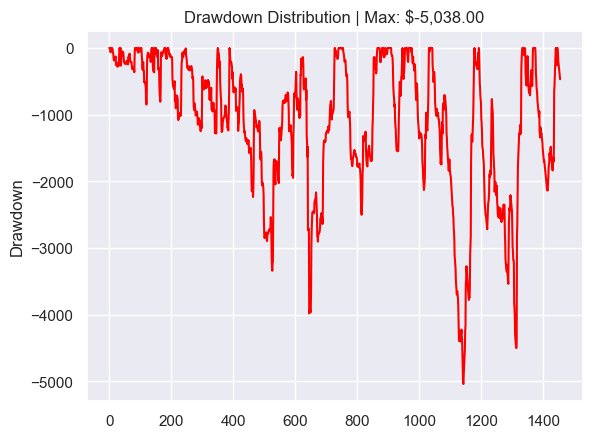

,Métrica,Trading System
0,Deposit,R$ 50000.00
1,Lucro,R$ 13561.00
2,CAGR,27.48%
3,Drawdown Max ($),R$ -5038.00
4,Drawdown Max (%),-10.08%


In [791]:
# Calcular o valor máximo acumulado até cada ponto
df['Max_Peak'] = df['System PnL'].cummax()

# Calcular o drawdown em termos financeiros
df['Drawdown'] = df['System PnL'] - df['Max_Peak']

# Encontrar o drawdown máximo financeiro
max_drawdown_financeiro = df['Drawdown'].min()

# Encontrar a data em que ocorreu o maior drawdown
data_max_drawdown = df[df['Drawdown'] == max_drawdown_financeiro]['Data'].values[0]
max_drawdown_percent = max_drawdown_financeiro*100/initial_deposit

df_metricas_drawdown = pd.DataFrame({
    'Métrica': ['Drawdown Max ($)', 
                'Drawdown Max (%)'],
    'Trading System': [f"R$ {max_drawdown_financeiro:.2f}", 
              f"{max_drawdown_percent:.2f}%"]
})

df_metricas = pd.concat([df_metricas,df_metricas_drawdown], ignore_index=True)

# print(f"Drawdown máximo financeiro: R$ {max_drawdown_financeiro:,.2f}")
# print(f'Drawdown max percent: {max_drawdown_percent:.2f}%')
# print(f"Data em que ocorreu o maior drawdown: {data_max_drawdown}")

plt.title(f'Drawdown Distribution | Max: ${max_drawdown_financeiro:,.2f}')
sns.lineplot(data=df['Drawdown'],color='red')
#pf.plot_drawdown_underwater(returns=df['Drawdown'])

plt.show()
df_metricas

Observamos um drawdown máximo de -R$5.038, o que representa um risco máximo de 10,07% sobre o valor total investido, representando apenas 33.58% do valor alocado em margem para a execução do portfolio (R$15.000).<br>

#### Distribuição de resultado dos trades

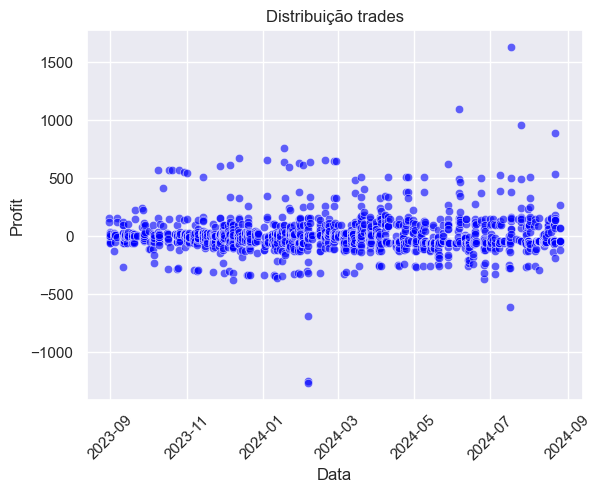

In [792]:
sns.scatterplot(data=df, x='Data', y='Profit', color='blue', alpha=0.6)
# Adicionar detalhes ao gráfico
plt.title('Distribuição trades')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.show()

Percebemos a distruibução bem uniforme, e os poucos outliers que aparecem existem tanto para trades perdedores quanto para trades vencedores.

#### Calculando a regressão linear e o seu R²

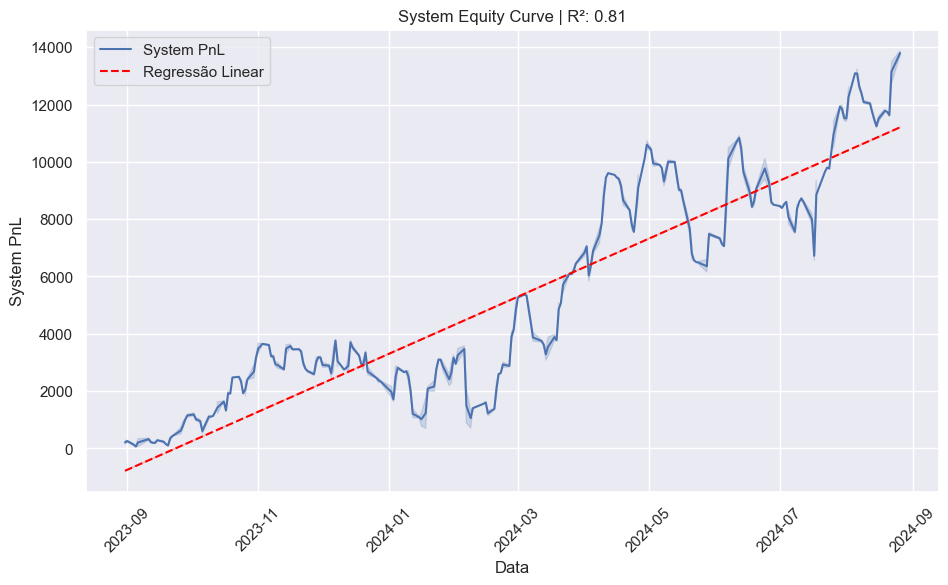

                 Métrica Trading System
0                Deposit    R$ 50000.00
1                  Lucro    R$ 13561.00
2                   CAGR         27.48%
3       Drawdown Max ($)    R$ -5038.00
4       Drawdown Max (%)        -10.08%
5  Curve Smoothness - R²           0.81


In [793]:
# Converta a coluna de datas em números para a regressão
df['Time_ordinal'] = df['Time'].map(pd.Timestamp.toordinal)

# Calcular a regressão linear
slope, intercept, r_value, p_value, std_err = linregress(df['Time_ordinal'], df['System PnL'])

# Calcular o R²
r_squared = r_value**2

# Adicionar a linha de regressão ao DataFrame
df['Regressao'] = intercept + slope * df['Time_ordinal']

# Adicionar R² ao nosso dataframe de métricas
df_metricas_lr = pd.DataFrame({'Métrica':['Curve Smoothness - R²'],'Trading System':[f'{r_squared:.2f}']})
df_metricas = pd.concat([df_metricas, df_metricas_lr], ignore_index=True)

# Plotar o gráfico
plt.figure(figsize=(11, 6))
sns.lineplot(data=df, x='Data', y='System PnL', label='System PnL')
sns.lineplot(data=df, x='Data', y='Regressao', color='red', linestyle='--', label='Regressão Linear')

plt.title(f'System Equity Curve | R²: {r_squared:.2f}')
plt.xlabel('Data')
plt.ylabel('System PnL')
plt.xticks(rotation=45)
plt.legend()
plt.show()
df_metricas

O R² representa o quanto o modelo linear consegue descrever os dados, o que para nós representa aqui a estabilidade da curva de capital. Com um R² de 0.81, o sistema apresenta uma estabilidade de ganhos satisfatória.

#### Calculando métricas de performance do sistema: taxa de acerto, payoff, edge, fator de lucro, expectativa matemática e fator de recuperação

In [794]:
# Filtrar operações vencedoras e perdedoras
num_vencedoras = df[df['Profit'] > 0].shape[0]
num_total = df.shape[0]

# Calcular a taxa de acerto
taxa_acerto = (num_vencedoras / num_total) * 100 if num_total > 0 else 0

# Filtrar operações vencedoras e perdedoras
vencedoras = df[df['Profit'] > 0]['Profit']
perdedoras = df[df['Profit'] < 0]['Profit']

# Calcular a média das operações vencedoras e perdedoras
media_vencedoras = vencedoras.mean() if not vencedoras.empty else 0
media_perdedoras = perdedoras.mean() if not perdedoras.empty else 0

payoff = media_vencedoras/-media_perdedoras

# Calcular o breakeven
breakeven = (1 / (1+payoff))*100

# Calculando edge
edge = taxa_acerto - breakeven

# Fator de Lucro
soma_lucros = df[df['Profit'] > 0]['Profit'].sum()
soma_perdas = df[df['Profit'] < 0]['Profit'].sum()
fator_lucro = soma_lucros / abs(soma_perdas) if soma_perdas != 0 else np.nan

# Expectativa Matemática
payoff_medio = media_vencedoras / -media_perdedoras
expectancy = (taxa_acerto / 100 * payoff_medio) - ((100 - taxa_acerto) / 100)
expectancy *= 100

# Fator de Recuperação
recovery_factor = (system_profit / -max_drawdown_financeiro)

# print(f"Taxa de Acerto: {taxa_acerto:.2f}%")
# print(f'Payoff médio: {payoff_medio:,.2f}')
# print(f'Edge: {edge:,.2f}%')
# print(f"Fator de Lucro: {fator_lucro:.2f}")
# print(f"Expectativa Matemática: {expectancy:.2f}%")

df_metricas_performance = pd.DataFrame({
    'Métrica': ['Taxa de Acerto', 
                'Payoff', 
                'Edge', 
                'Fator de Lucro',
                'Fator de Recuperação', 
                'Expectativa Matemática',],
    'Trading System': [f"{taxa_acerto:.2f}%", 
              f"{payoff:,.2f}", 
              f"{edge:,.2f}%", 
              f"{fator_lucro:.2f}",
              f'{recovery_factor:.2f}', 
              f"{expectancy:.2f}%"
              ]
})

df_metricas = pd.concat([df_metricas, df_metricas_performance], ignore_index=True)

df_metricas

,Métrica,Trading System
0,Deposit,R$ 50000.00
1,Lucro,R$ 13561.00
2,CAGR,27.48%
3,Drawdown Max ($),R$ -5038.00
4,Drawdown Max (%),-10.08%
5,Curve Smoothness - R²,0.81
6,Taxa de Acerto,47.77%
7,Payoff,1.27
8,Edge,3.76%
9,Fator de Lucro,1.22


#### Calculando a volatilidade do sistema

In [795]:
# Calcular os retornos diários
retornos_diarios_sistema = (initial_deposit + df['System PnL']).pct_change().dropna()

# Calcular a volatilidade (desvio padrão dos retornos diários)
volatilidade_diaria_sistema = retornos_diarios_sistema.std() * 100
dias_de_negociacao_por_ano = 252
volatilidade_anualizada_sistema = volatilidade_diaria_sistema * np.sqrt(dias_de_negociacao_por_ano)

df_metricas_vol = pd.DataFrame({
    'Métrica': ['Volatilidade Diária', 'Volatilidade Anual'],
    'Trading System': [f"{volatilidade_diaria_sistema:.2f}%", f"{volatilidade_anualizada_sistema:.2f}%"]
})

df_metricas = pd.concat([df_metricas, df_metricas_vol], ignore_index=True)

# # Exibir a volatilidade
# print(f"Volatilidade Diária Sistema: {volatilidade_diaria_sistema:.4f}%")
# print(f"Volatilidade Anualizada Sistema: {volatilidade_anualizada_sistema:.4f}%")

df_metricas

,Métrica,Trading System
0,Deposit,R$ 50000.00
1,Lucro,R$ 13561.00
2,CAGR,27.48%
3,Drawdown Max ($),R$ -5038.00
4,Drawdown Max (%),-10.08%
5,Curve Smoothness - R²,0.81
6,Taxa de Acerto,47.77%
7,Payoff,1.27
8,Edge,3.76%
9,Fator de Lucro,1.22


<b>Legenda:</b> <br> 
CAGR: Retorno composto anualizado <br>
Drawdown Max: Maior rebaixamento na curva de capital observado <br>
Curve Smoothness - R²: avalia o ajuste do model de regressão linear aos dados - representa aqui a estabilidade da curva de capital<br>


In [796]:
df_metricas

,Métrica,Trading System
0,Deposit,R$ 50000.00
1,Lucro,R$ 13561.00
2,CAGR,27.48%
3,Drawdown Max ($),R$ -5038.00
4,Drawdown Max (%),-10.08%
5,Curve Smoothness - R²,0.81
6,Taxa de Acerto,47.77%
7,Payoff,1.27
8,Edge,3.76%
9,Fator de Lucro,1.22


#### Obtendo dados do benchmark - Ibovespa<br>

In [797]:
# Coletar dados da API
symbol = '^BVSP'
df_ibov = yf.download(symbol, start=inicio, end=fim)
close_prices = df_ibov['Close']

[*********************100%***********************]  1 of 1 completed


##### Calculando retornos, drawdown máximo e volatilidade do benchmark e adicionando ao dataframe

Valorização IBOV período: 18.17%
Volatilidade Diária IBOV: 0.82%
Volatilidade Anualizada IBOV: 13.03%
Drawdown Máximo IBOV: -11.22%
Drawdown Máximo Financeiro: R$ -5609.79


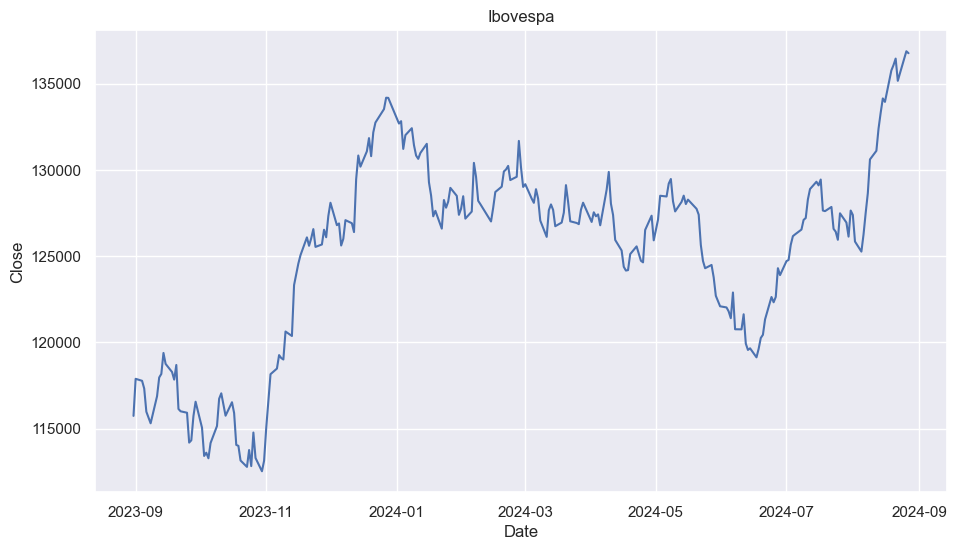

In [798]:
# Calcular o retorno absoluto total
preco_inicial = close_prices.iloc[0]
preco_final = close_prices.iloc[-1]
retorno_absoluto_total = (preco_final - preco_inicial) / preco_inicial

# Calcular os retornos diários
retornos_diarios = close_prices.pct_change().dropna()

# Calcular o drawdown máximo
acumulado_buyhold = close_prices.cummax()
drawdown_buyhold = (close_prices - acumulado_buyhold) / acumulado_buyhold
drawdown_maximo_percentual_buyhold = drawdown_buyhold.min() * 100

# Valor financeiro do drawdown máximo
drawdown_maximo_financeiro = drawdown_buyhold.min() * initial_deposit

# Calcular a volatilidade (desvio padrão dos retornos diários)
volatilidade_diaria_ibov = retornos_diarios.std() * 100

# Calcular a volatilidade anualizada (multiplicando pela raiz quadrada do número de dias de negociação por ano)
dias_de_negociacao_por_ano = 252
volatilidade_anualizada_ibov = volatilidade_diaria_ibov * np.sqrt(dias_de_negociacao_por_ano)

# Calcular lucro do buy and hold no benchmark
lucro_buyhold = retorno_absoluto_total*initial_deposit
valor_final_buyhold = initial_deposit + lucro_buyhold
num_anos = (df['Time'].max() - df['Time'].min()).days / 365.25
cagr_buyhold = (valor_final_buyhold / initial_deposit) ** (1 / num_anos) - 1
cagr_buyhold *= 100

# Calcular fator de recuperação
fr_buyhold = lucro_buyhold / -drawdown_maximo_financeiro

# Agora, adicione uma nova coluna ao dataframe 'df_metricas'
df_metricas['Benchmark(Ibovespa)'] = [
    f'R$ {initial_deposit:.2f}',  # Supondo que você não tem valores correspondentes para 'Deposit' na linha 0
    f'R$ {lucro_buyhold:.2f}',  # Nem para 'System Profit' na linha 1
    f'{cagr_buyhold:.2f}%',  # Nem para 'CAGR' na linha 2
    f"R$ {drawdown_maximo_financeiro:.2f}",  # Drawdown Máximo (R$) na linha 3
    f"{drawdown_maximo_percentual_buyhold:.2f}%",  # Drawdown Máximo (%) na linha 4
    "-",  # Supondo que você não tem valores correspondentes para 'Curve Smoothness - R²' na linha 5
    "-",  # Nem para 'Taxa de Acerto' na linha 6
    "-",  # Nem para 'Payoff' na linha 7
    "-",  # Nem para 'Edge' na linha 8
    "-",  # Nem para 'Fator de Lucro' na linha 9
    f'{fr_buyhold:.2f}',  # Nem para 'Fator de Recuperação' na linha 10
    "-",  # Nem para 'Expectativa Matemática' na linha 11
    f"{volatilidade_diaria_ibov:.2f}%",  # Volatilidade Diária na linha 12
    f"{volatilidade_anualizada_ibov:.2f}%"  # Volatilidade Anualizada na linha 13
]


# Resultados
plt.figure(figsize=(11, 6))
sns.lineplot(close_prices)
plt.title('Ibovespa')


print(f"Valorização IBOV período: {retorno_absoluto_total*100:.2f}%")
print(f"Volatilidade Diária IBOV: {volatilidade_diaria_ibov:.2f}%")
print(f"Volatilidade Anualizada IBOV: {volatilidade_anualizada_ibov:.2f}%")
print(f"Drawdown Máximo IBOV: {drawdown_maximo_percentual_buyhold:.2f}%")
print(f"Drawdown Máximo Financeiro: R$ {drawdown_maximo_financeiro:.2f}")

In [799]:
df_metricas

,Métrica,Trading System,Benchmark(Ibovespa)
0,Deposit,R$ 50000.00,R$ 50000.00
1,Lucro,R$ 13561.00,R$ 9086.59
2,CAGR,27.48%,18.41%
3,Drawdown Max ($),R$ -5038.00,R$ -5609.79
4,Drawdown Max (%),-10.08%,-11.22%
5,Curve Smoothness - R²,0.81,-
6,Taxa de Acerto,47.77%,-
7,Payoff,1.27,-
8,Edge,3.76%,-
9,Fator de Lucro,1.22,-


Consideramos a alocação financeira do valor total do depósito inicial no benchmark, a título de comparação.<br>

Observamos que durante o período analisado o benchmark se valorizou em 18.17%, um valor considerável considerando ser um mercado emergente e a janela de observação de 1 ano.<br>
Observamos o drawdown de 11.22%, valor próximo ao drawdown observado no sistema.<br>


Sua volatilidade anual foi de 13.03%, um valor expressivamente maior do que o do sistema (4.66%). <br>
Vamos também aqui calcular sua regressão linear e compará-la ao sistema.

##### Calculando regressão linear do benchmark

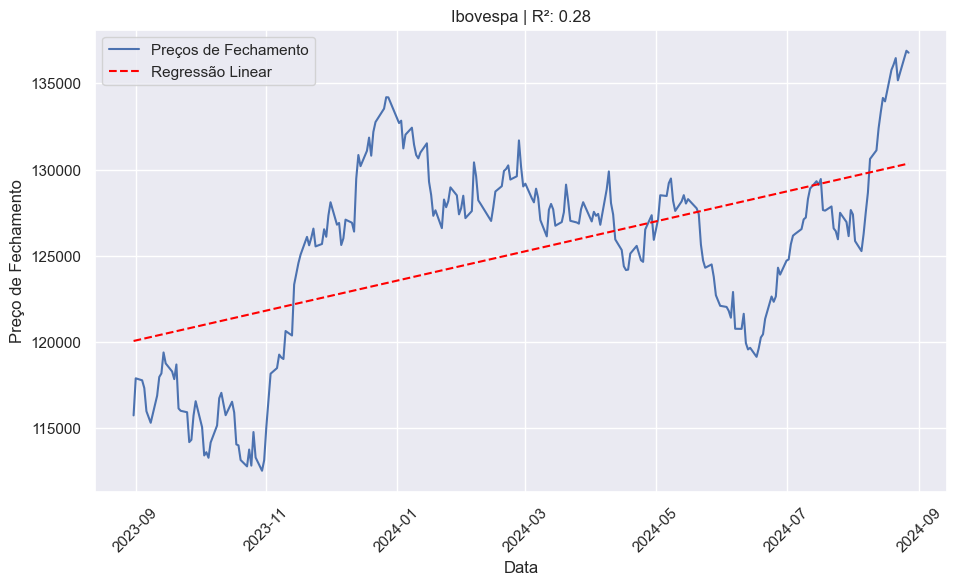

In [800]:
df_ibov.reset_index(inplace=True)  # Resetar o índice para usar a coluna de datas

# Converter a coluna de datas em números para a regressão
df_ibov['Time_ordinal'] = df_ibov['Date'].map(pd.Timestamp.toordinal)

# Calcular a regressão linear
slope, intercept, r_value, p_value, std_err = linregress(df_ibov['Time_ordinal'], df_ibov['Close'])

# Calcular o R²
r_squared_ibov = r_value**2

# Adicionar a linha de regressão ao DataFrame
df_ibov['Regressao'] = intercept + slope * df_ibov['Time_ordinal']

# Plotar o gráfico
plt.figure(figsize=(11, 6))
sns.lineplot(data=df_ibov, x='Date', y='Close', label='Preços de Fechamento')
sns.lineplot(data=df_ibov, x='Date', y='Regressao', color='red', linestyle='--', label='Regressão Linear')

plt.title(f'Ibovespa | R²: {r_squared_ibov:.2f}')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#### Comparando o resultado entre o sistema e o benchmark

Text(0.5, 1.0, 'System Equity Curve / R²: 0.81')

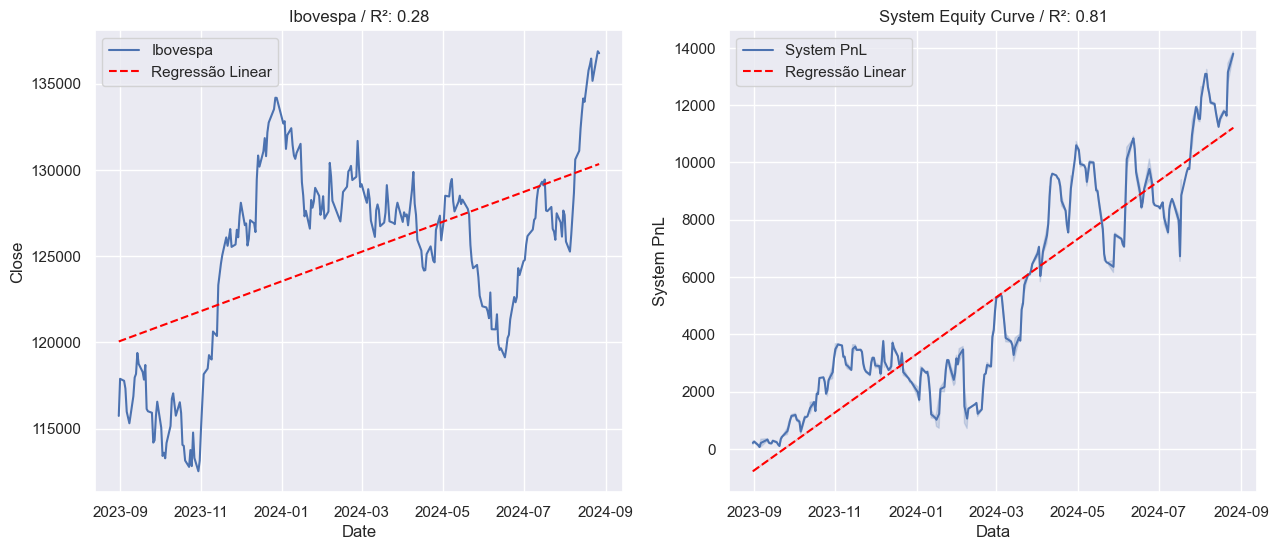

In [801]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 linha, 2 colunas

sns.lineplot(data=df_ibov, x='Date', y='Close', label='Ibovespa',ax=axes[0])
sns.lineplot(data=df_ibov, x='Date', y='Regressao', color='red', linestyle='--', label='Regressão Linear', ax=axes[0])
axes[0].set_title(f'Ibovespa / R²: {r_squared_ibov:.2f}')

sns.lineplot(data=df, x='Data', y='System PnL', label='System PnL',ax=axes[1])
sns.lineplot(data=df, x='Data', y='Regressao', color='red', linestyle='--', label='Regressão Linear', ax=axes[1])
axes[1].set_title(f'System Equity Curve / R²: {r_squared:.2f}')

Considerando o buy and hold do benchmark*, observamos um valor R² de 0.28, bem inferior ao do sistema em estudo que possui 0.81.<br>
###### *Necessário ser feito através de algum derivativo, pois o Ibovespa é uma índice de carteira teórica

#### Calculando a taxa Selic para o período

Valor médio da taxa Selic no período: 11.42%


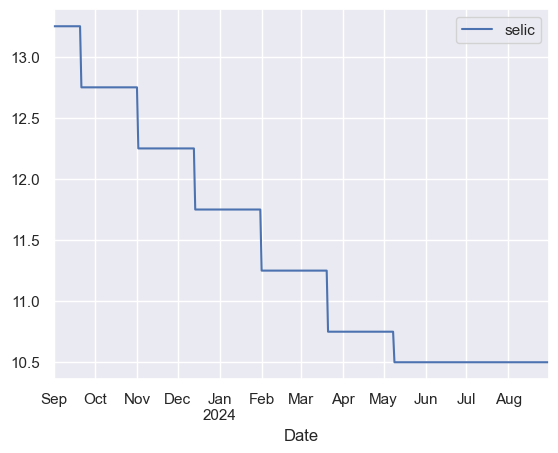

In [802]:
# Obtem dados da API do Banco Central
selic = sgs.get({'selic': 432},start = inicio,end = fim)

valor_medio_selic = selic['selic'].mean()
taxa_livre_risco = valor_medio_selic/100

#Visualizar dados
sns.set_theme()
#selic.plot(figsize=(15,20))
selic.plot()
print(f"Valor médio da taxa Selic no período: {valor_medio_selic:.2f}%")


Percebe-se um claro cenário de afrouxamento da política monetária no período.

Vamos calcular o valor total obtido na parte do nosso portfolio alocado em renda fixa.<br>
Adicionamos esse valor ao lucro total obtido na totalidade do investimento e utilizaremos estes valores para calcular as métricas de retorno ajustado ao risco

#### Calculando mais indicadores de performance ajustada ao risco

In [803]:
# Sharpe Ratio
retorno_sistema = (system_profit)/initial_deposit
desvio_padrao = df['Profit'].std() / initial_deposit
sharpe_ratio = (retorno_sistema - taxa_livre_risco) / (volatilidade_anualizada_sistema/100) if desvio_padrao != 0 else np.nan

# Calmar Ratio
retorno_anual_sistema = (valor_final_sistema / initial_deposit - 1) * 100
calmar_ratio = retorno_anual_sistema / abs(max_drawdown_financeiro) if max_drawdown_financeiro != 0 else np.nan

# VaR
conf_level = 0.95
var = df['Profit'].quantile(1 - conf_level)

# Expectancy
payoff_medio = media_vencedoras / -media_perdedoras
expectancy = (taxa_acerto / 100 * payoff_medio) - ((100 - taxa_acerto) / 100)
expectancy *= 100

# AHPR (Assumindo que cada trade é independente e os retornos são médios diários)
ahpr = df['Profit'].mean()

# GHPR
geometric_return = np.exp(np.log1p(df['Profit']).mean()) - 1

df_metricas_risco = pd.DataFrame({
    'Métrica': ['Sharpe Ratio', 
                'Calmar Ratio', 
                'VaR (95%)', 
                'AHPR', 
                'GHPR'],
    'Trading System': [f"{sharpe_ratio:.2f}", 
              f"{calmar_ratio:,.2f}", 
              f"{var:,.2f}", 
              f"{ahpr:.2f}", 
              f"{geometric_return:.2f}%"]
})

df_metricas = pd.concat([df_metricas, df_metricas_risco], ignore_index=True)

# Exibindo os resultados

# print(f"CAGR: {cagr*100:.2f}%")
# print(f'Drawdown max: {max_drawdown_financeiro*100/initial_deposit:.2f}%')
# print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
# print(f"Calmar Ratio: {calmar_ratio:.2f}")
# print(f"VaR (95%): R$ {var:,.2f}")
# print(f"AHPR: {ahpr:.2f}")
# print(f"GHPR: {geometric_return*100:.2f}%")

c:\Users\davim\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\davim\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Resultados <br>
Temos os resultados da nossas métricas do sistema

In [804]:
df_metricas

,Métrica,Trading System,Benchmark(Ibovespa)
0,Deposit,R$ 50000.00,R$ 50000.00
1,Lucro,R$ 13561.00,R$ 9086.59
2,CAGR,27.48%,18.41%
3,Drawdown Max ($),R$ -5038.00,R$ -5609.79
4,Drawdown Max (%),-10.08%,-11.22%
5,Curve Smoothness - R²,0.81,-
6,Taxa de Acerto,47.77%,-
7,Payoff,1.27,-
8,Edge,3.76%,-
9,Fator de Lucro,1.22,-


#### Calculando rendimento da renda fixa <br>
Lembrando que alocamos 70% do nosso capital em renda fixa, podemos calcular este seu rendimento para o período.

In [805]:

fixedincome_capital_total = initial_deposit  * taxa_livre_risco

fixedincome_alocated_capital = initial_deposit * 0.70
fixedincome_yield = fixedincome_alocated_capital * valor_medio_selic/100

lost_fixedincome_yield = fixedincome_capital_total - fixedincome_yield
lost_fixedincome_yield
free_risk_return_lost = lost_fixedincome_yield / initial_deposit
free_risk_return_lost

profit_total = system_profit + fixedincome_yield

valor_final_total = initial_deposit + profit_total
num_anos = (df['Time'].max() - df['Time'].min()).days / 365.25
cagr_total = (valor_final_total / initial_deposit) ** (1 / num_anos) - 1
cagr_total *= 100

# df_metricas_rendafixa = pd.DataFrame({
#     'Métrica': ['Lucro Renda Fixa', 'Lucro Total','CAGR Total'],
#     'Trading System': [f"R$ {fixedincome_yield:.2f}", f"R$ {profit_total:.2f}", f"{cagr_total:.2f}%"]
# })

# df_metricas = pd.concat([df_metricas, df_metricas_rendafixa], ignore_index=True)

# Exibe os valores calculados
print(f"Lucro da Renda Fixa: R$ {fixedincome_yield:.2f}")
print(f"Lucro Total: R$ {profit_total:.2f}")
print(f"CAGR Total: {cagr_total:.2f}%")


Lucro da Renda Fixa: R$ 3995.44
Lucro Total: R$ 17556.44
CAGR Total: 35.59%


### Considerações finais <br>



In [812]:
df_metricas

,Métrica,Trading System,Benchmark(Ibovespa)
0,Deposit,R$ 50000.00,R$ 50000.00
1,Lucro,R$ 13561.00,R$ 9086.59
2,CAGR,27.48%,18.41%
3,Drawdown Max ($),R$ -5038.00,R$ -5609.79
4,Drawdown Max (%),-10.08%,-11.22%
5,Curve Smoothness - R²,0.81,-
6,Taxa de Acerto,47.77%,-
7,Payoff,1.27,-
8,Edge,3.76%,-
9,Fator de Lucro,1.22,-


#### Pontos chave:

 - Rentabilidade: sistema apresentou 27.48% de rentabilidade contra 18.17% do Ibovespa<br>
 - Volatilidade: sistema apresentou 4.66% de volatilidade anual contra 13.03% do Ibovespa<br>
 - Sharpe Ratio: 3.37, desconsiderando os rendimentos das aplicações de renda fixa.
 - Drawdown semelhante entre os dois, porém retorno superior no portfolio.
 - R² superior no portfolio, indicando uma melhor e mais estável distribuição de retornos.

  Para fins de comparação de performance, foi considerado o buy and hold benchmark de todo o valor depositado, o que impossibilita o uso de capital para outras alocações potenciais. No entanto, no sistema, apenas 30% do capital foi alocado, permitindo que os outros 70% pudessem gerar um rendimento adicional de R$ 3.995,44 em investimentos de renda fixa. Isso resultou em um valor total de R$ 17.556,44, representando um retorno anualizado de 35,59%, para um drawdown máximo de 10,07%.<br>

 De forma geral, observa-se que o investidor que utilizou o sistema com a alocação de capital estudada obteve um retorno muito superior ao benchmark, praticamente dobrando a rentabilidade, mesmo considerando um cenário de afrouxamento da política monetária e a valorização expressiva do Ibovespa em torno de 18%. Além disso, o investidor também conseguiu uma melhor distribuição dos retornos e demonstrou uma performance com métricas de risco e retorno ajustado ao risco bastante saudáveis.